(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import lfilter, butter
from itertools import product

In [2]:
import reconstructionutils as ru
import cutility as cu

In [3]:
import seaborn as sns
sns.set_theme()

In [4]:
#from scipy.interpolate import splev, splrep

In [5]:
sns.set_theme(style='dark')

<IPython.core.display.Javascript object>


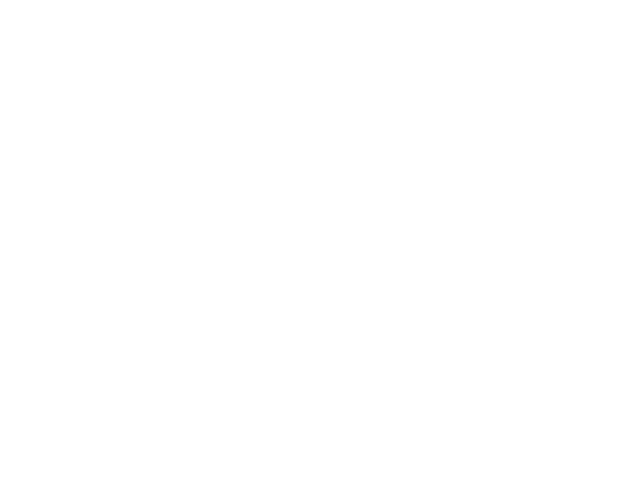

NameError: name 'z_1_filtered' is not defined

In [6]:
%matplotlib notebook
plt.subplot(2, 2, 1)
plt.title('$E_1$-$W_3$ plane')
plt.plot(z_1_filtered, z_2_filtered, label='without offset')
plt.plot(series_full[0], series_full[1], label='with offset')
plt.xticks([0], [])
plt.yticks([0])
plt.ylabel('$W_3$')
plt.grid()
plt.legend(fontsize='x-small')

plt.subplot(2, 2, 2)
plt.title('$E_4$-$W_3$ plane')
plt.plot(z_3_filtered, z_2_filtered)
plt.plot(series_full[2], series_full[1])
plt.xticks([0])
plt.yticks([0], [])
plt.xlabel('$W_4$')
plt.grid()

plt.subplot(2, 2, 3)
plt.title('$E_1$-$W_4$ plane')
plt.plot(z_1_filtered, z_3_filtered)
plt.plot(series_full[0], series_full[2])
plt.xticks([0])
plt.yticks([0])
plt.xlabel('$E_1$')
plt.ylabel('$W_4$')
plt.grid()

ax = plt.subplot(2, 2, 4, projection='3d')
plt.plot(z_1_filtered, z_2_filtered, z_3_filtered, label='without offset')
plt.plot(series_full[0], series_full[1], series_full[2], label='with offset')
plt.xticks([0])
plt.yticks([0])
ax.set_zticks([0])
plt.title('Phaseplot')

plt.tight_layout()
plt.show()

In [4]:
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.plot(z_1_original, z_2_original, z_3_original)
ax.plot(z_1_filtered, z_2_filtered, z_3_filtered)
ax.plot(series_full[0], series_full[1], series_full[2])

<IPython.core.display.Javascript object>

NameError: name 'z_1_filtered' is not defined

# The fit 
One wants to obtain coefficients $\vec{p}$ of a function $f(\vec{x};\vec{p})$ from minimizing the following term:

$$
\frac{1}{\sum_i^n w_i}\sum_i^n w_i (f(\vec{x};\vec{p})-z_i)^2
$$

Wich can be done by


$$
\frac{\partial}{\partial p_k}\sum_i^n w_i (f(\vec{x};\vec{p})-z_i)^2 = \sum_i^n w_i (f(\vec{x};\vec{p})-z_i)\frac{\partial}{\partial p_k}f(\vec{x};\vec{p})=0
$$

When written as a matrix equation $A\vec{x}=b$:

$$
\begin{pmatrix}
\sum_i^n w_i \cdot x_{1,i}^2 & \sum_i^n w_i \cdot x_{1,i} x_{2,1} & \dots & & \\
\sum_i^n w_i \cdot x_{1,i} x_{2,i} & \ddots\\
\vdots \\
\\
\\
\end{pmatrix}
\cdot
\vec{p}
=
\begin{pmatrix}
\sum_i^n w_i \cdot z_i x_{1,i} \\
\sum_i^n w_i \cdot z_i x_{2,i} \\
\vdots \\
\\
\\
\end{pmatrix}
$$

Using a weighting function $w$.

In [5]:
# import multichannel ecg data by R.Moss
data = pd.read_csv('./ECG_data/moss/MeasuredECG.txt', sep=" ", header=1)
data.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [6]:
# calculating dt
#data#['time']

In [7]:
# since there is an offset between s[0] and s[-1] one needs to manipulate
# the series that is is truly periodical. this is achieved by tilting the series
tilt_series = lambda t, z: z[t] - (z[-1] - z[0]) * t / len(z)

In [8]:
# original time series
# selected by correlation analysis
z_1_original = np.array(data['E1'])
z_2_original = np.array(data['W3'])
z_3_original = np.array(data['W4'])

timesteps_ = data['time']

series_original = [z_1_original, z_2_original, z_3_original]

In [9]:
# spline the series
#w = np.ones(z_1_original.shape[0])#
#s = 10
#
#t_ = np.linspace(0, len(timesteps_), 1000)
#
#series_spline = []
#series_derivate = []
#for el in series_original:
#    spl = splrep(timesteps_, el, w=w, k=5, s=s)
#    
#    yspl = splev(t_, spl)
#    dyspl = splev(t_, spl, der=1)
#    
#    series_spline.append(yspl)
#    series_derivate.append(dyspl)

In [10]:
# procedure:
# 1. tilt the series, make it full periodical
# 2. filter the series, lowpass filter
# 3. add offset to each series
# 4. tilt it the second time
# 5. cut into intervals

In [11]:
# 1. tilt
z_1_periodical = tilt_series(np.arange(0, len(z_1_original)), z_1_original)
z_2_periodical = tilt_series(np.arange(0, len(z_2_original)), z_2_original)
z_3_periodical = tilt_series(np.arange(0, len(z_3_original)), z_3_original)

In [12]:
from scipy import signal

In [13]:
# 2. filter the signals with a lowpass to remove unwanted jitter
b, a = butter(3, .01)  # 0.83 cutoff -> 50 Hz, .0415 -> 25 Hz, 0.027 -> ca. 16 Hz

#b, a = signal.butter(N=3, Wn=5., fs=996)

z_1_filtered = lfilter(b, a, z_1_periodical)
z_2_filtered = lfilter(b, a, z_2_periodical)
z_3_filtered = lfilter(b, a, z_3_periodical)

<IPython.core.display.Javascript object>


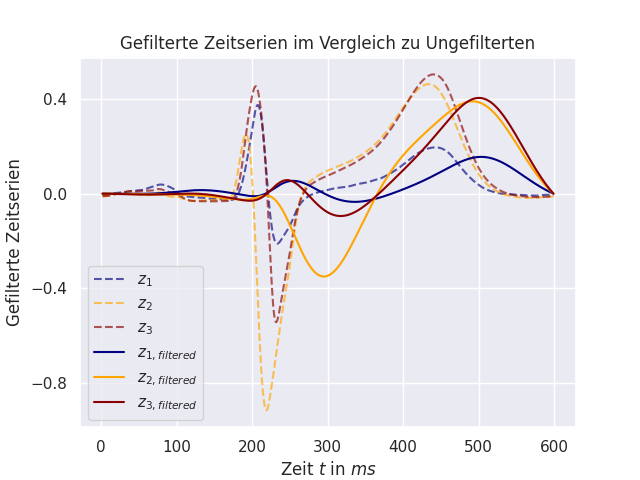

In [14]:
%matplotlib notebook
plt.plot(timesteps_, z_1_periodical, linestyle='--', label='$z_1$', alpha=.65, c='navy')
plt.plot(timesteps_, z_2_periodical, linestyle='--', label='$z_2$', alpha=.65, c='orange')
plt.plot(timesteps_, z_3_periodical, linestyle='--', label='$z_3$', alpha=.65, c='darkred')

plt.plot(timesteps_, tilt_series(np.arange(0, len(z_1_filtered)), z_1_filtered), label='$z_{1,filtered}$', c='navy')
plt.plot(timesteps_, tilt_series(np.arange(0, len(z_2_filtered)), z_2_filtered), label='$z_{2,filtered}$', c='orange')
plt.plot(timesteps_, tilt_series(np.arange(0, len(z_3_filtered)), z_3_filtered), label='$z_{3,filtered}$', c='darkred')

#plt.xlabel('Time $t$ in $ms$')
plt.xlabel('Zeit $t$ in $ms$')
#plt.ylabel('Filtered time series')
plt.ylabel('Gefilterte Zeitserien')
plt.yticks([-.8, -.4, 0, .4])
plt.legend()
#plt.title('unfiltered time series compared to filtered')
plt.title('Gefilterte Zeitserien im Vergleich zu Ungefilterten')
#plt.grid()
plt.show()

<IPython.core.display.Javascript object>


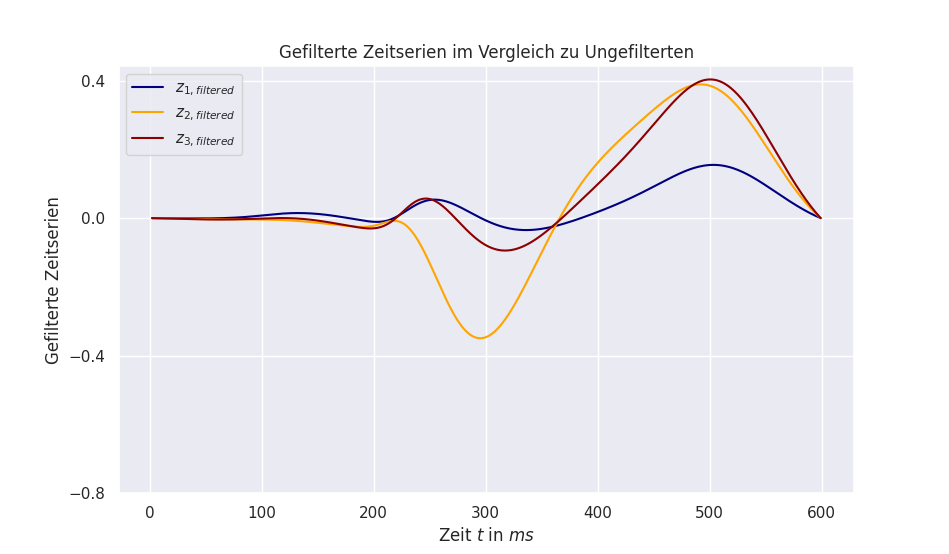

In [16]:
%matplotlib notebook
#plt.plot(timesteps_, z_1_periodical, linestyle='--', label='$z_1$', alpha=.65, c='navy')
#plt.plot(timesteps_, z_2_periodical, linestyle='--', label='$z_2$', alpha=.65, c='orange')
#plt.plot(timesteps_, z_3_periodical, linestyle='--', label='$z_3$', alpha=.65, c='darkred')

plt.plot(timesteps_, tilt_series(np.arange(0, len(z_1_filtered)), z_1_filtered), label='$z_{1,filtered}$', c='navy')
plt.plot(timesteps_, tilt_series(np.arange(0, len(z_2_filtered)), z_2_filtered), label='$z_{2,filtered}$', c='orange')
plt.plot(timesteps_, tilt_series(np.arange(0, len(z_3_filtered)), z_3_filtered), label='$z_{3,filtered}$', c='darkred')

#plt.xlabel('Time $t$ in $ms$')
plt.xlabel('Zeit $t$ in $ms$')
#plt.ylabel('Filtered time series')
plt.ylabel('Gefilterte Zeitserien')
plt.yticks([-.8, -.4, 0, .4])
plt.legend()
#plt.title('unfiltered time series compared to filtered')
plt.title('Gefilterte Zeitserien im Vergleich zu Ungefilterten')
#plt.grid()
plt.show()

<IPython.core.display.Javascript object>


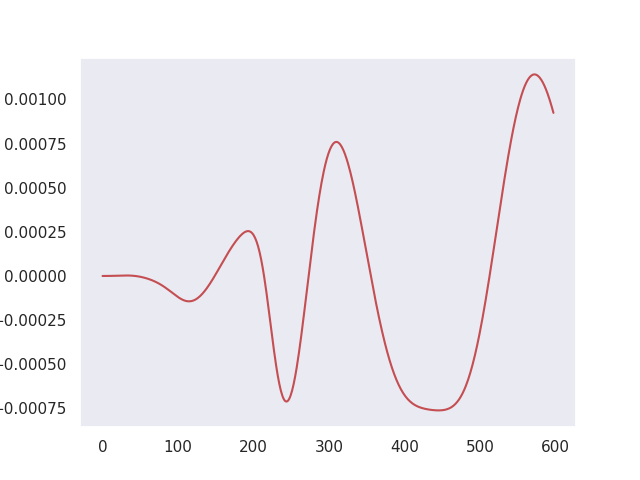

In [17]:
%matplotlib notebook
b, a = butter(3, .01)  # 0.83 cutoff -> 50 Hz, .0415 -> 25 Hz, 0.027 -> ca. 16 Hz
__z_1_filtered = lfilter(b, a, z_1_periodical)

b, a = signal.butter(N=3, Wn=5.01, fs=996)#996)
___z_1_filtered = lfilter(b, a, z_1_periodical)

plt.plot(__z_1_filtered - ___z_1_filtered, c='r')
#plt.plot(__z_1_filtered)

In [423]:
#sns.reset_orig()
sns.set_theme(style='dark')

<IPython.core.display.Javascript object>


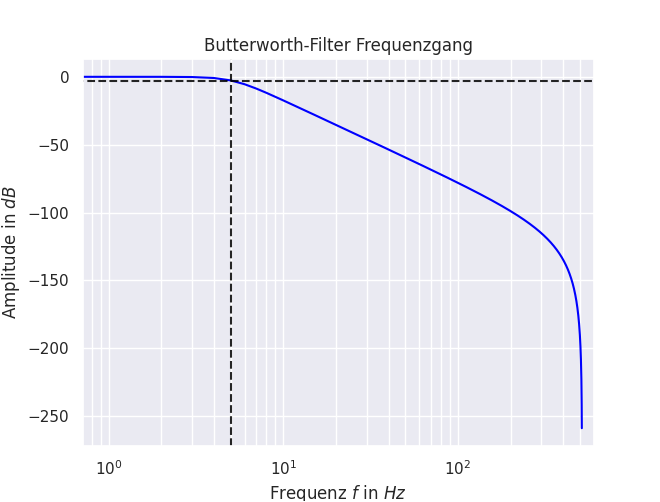

<ipython-input-425-931c1a10dfda>:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 600])


In [425]:
%matplotlib notebook
#b, a = signal.butter(4, 100, 'low', analog=True)
b, a = signal.butter(N=3, Wn=5., fs=996)
w, h = signal.freqz(b, a)

plt.plot(20 * np.log10(abs(h)), c='blue')
plt.plot([0, 1000], [-3, -3], linestyle='--', c='black', alpha=.85)
plt.axvline(5, linestyle='--', color='black', alpha=.85)

plt.ylabel('Amplitude in $dB$')
plt.xlabel('Frequenz $f$ in $Hz$')

plt.xscale('log')
plt.title('Butterworth-Filter Frequenzgang')

plt.xlim([0, 600])

#plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

In [15]:
# 3. add offset
z_1_filtered += 0
z_2_filtered += -1e-1  # -1e-1
z_3_filtered += 1e-1  # 1e-1

In [16]:
# 4. second time tilting
z_1_ = tilt_series(np.arange(0, len(z_1_filtered)), z_1_filtered)
z_2_ = tilt_series(np.arange(0, len(z_2_filtered)), z_2_filtered)
z_3_ = tilt_series(np.arange(0, len(z_3_filtered)), z_3_filtered)

In [17]:
z_1_derivate_full = np.gradient(z_1_, )
z_2_derivate_full = np.gradient(z_2_, )
z_3_derivate_full = np.gradient(z_3_, )

series_full = [z_1_, z_2_, z_3_]
series_derivate_full = [z_1_derivate_full, z_2_derivate_full, z_3_derivate_full]

<IPython.core.display.Javascript object>


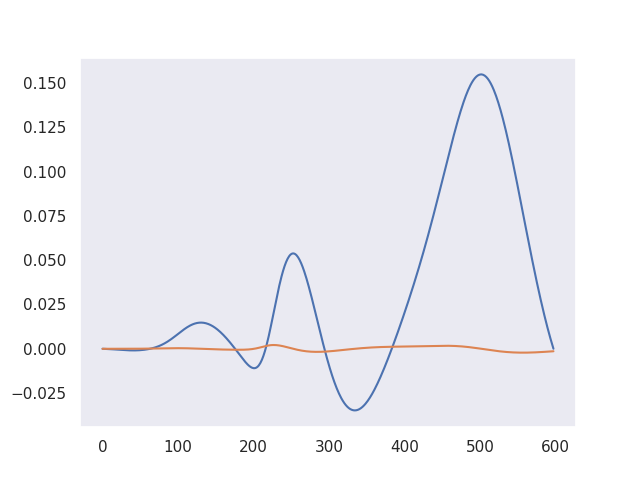

In [18]:
%matplotlib notebook
plt.plot(z_1_)
plt.plot(z_1_derivate_full)
plt.show()

In [24]:
# DEBUG
# using SPLINE here
#series_full = series_spline
#series_derivate_full = series_derivate

In [19]:
intervals = [(0, 160),
             (160, 170),
             (170, 280),
             (280, 310),
             (310, 330),
             (330, 350),
             (350, 470),
             
             (470, 550),
             
             (550, 570),
             (570, -1),
            ]  # (min, max) # this works!

#k = lambda c: int((c / len(z_1_)) * len(series_full[0])) if c != -1 else -1
#intervals = [(k(li), k(gi)) for li, gi in intervals]

# having a interval change every ten steps
#intervals = []
#interval_size = 97
#for i in range(len(series_full[0])):
#    if i % interval_size == 0:
#        intervals.append((i, i + interval_size))

#intervals = [(0,-1)]

In [20]:
series_intervals = []
for i in range(len(intervals)):
    li, gi = intervals[i]
    
    # create weighting function
    #blend = 3
    #amplitude = .15  # plus from normal level (1)
    #weighting = np.ones(np.shape(z_1_[li:gi])) + np.asarray([amplitude if \
    #                                                                     len(z_1_[li:gi]) - blend <= i \
    #                                                                   or \
    #                                                                     i < blend \
    #                                                                   else 0 \
    #                                                         for i in range(len(z_1_[li:gi]))])
    weighting = np.ones(np.shape(series_full[0][li:gi]))
    weighting[-10:] = 2.1
    #weighting[-1] = 2.#10.
    weighting[0] = 2.
    
    #if li not in (80, 170, 180, 220, 230, 340, 360, 390, 500):
    #    weighting[-1] = 1.1
    #if li in (260, 270, 350, 370, 570):
    #    weighting[-1] = 1.05
    #if li in (400,):
    #    weighting[-1] = 1.15
    #if li in (590,):
    #    weighting[0] = 1.05
    #    weighting[-1] = 1.015
    
    if gi == -1:
        # sonderfall
        #weighting[:5] = 10
        weighting[-10:] = 3.2#3.
        #weighting[-3:] = 20.#3.2
        weighting[-1] = 3.2
        
    if li == 0:
        # sonderfall
        weighting[0] = 2.9#3.#2.1

        
    series_intervals.append([[
                              series_full[0][li:gi],  # system time series (interval)
                              series_full[1][li:gi],
                              series_full[2][li:gi],
                             ],
                             [
                              series_derivate_full[0][li:gi],  # system time series derivates (cut from full)
                              series_derivate_full[1][li:gi],
                              series_derivate_full[2][li:gi],
                             ],
                             timesteps_[li:gi],  # timesteps for interval
                             weighting,  # weighting function for interval
                            ]
                           )

In [21]:
sns.set_theme()

<IPython.core.display.Javascript object>


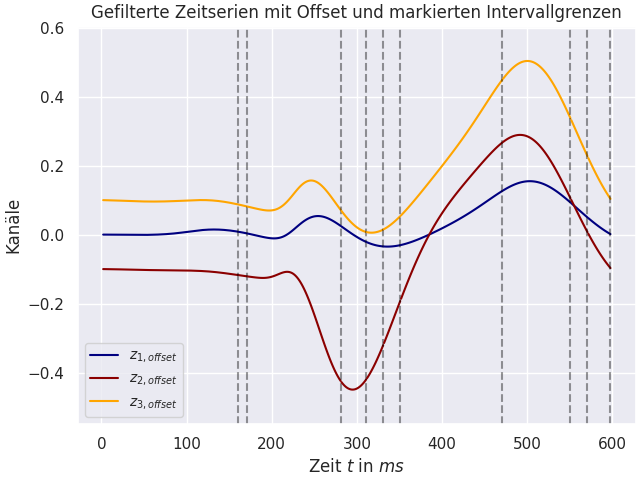

In [22]:
%matplotlib notebook
fig = plt.figure(constrained_layout=True)

f_ax1 = fig.add_subplot()
#f_ax1.set_title('Filtered time series with offset and marked intervals')
f_ax1.set_title('Gefilterte Zeitserien mit Offset und markierten Intervallgrenzen')
for i in range(len(series_intervals)):
    el = series_intervals[i]
    series = el[0]
    
    if i == 0:
        f_ax1.plot(el[2], series[0], c='navy', label='$z_{1,offset}$')
        f_ax1.plot(el[2], series[1], c='darkred', label='$z_{2,offset}$')
        f_ax1.plot(el[2], series[2], c='orange', label='$z_{3,offset}$')
    else:
        f_ax1.plot(el[2], series[0], c='navy')
        f_ax1.plot(el[2], series[1], c='darkred')
        f_ax1.plot(el[2], series[2], c='orange')
    
    f_ax1.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(series_full[1])-.1, np.max(series_full[2])+.1], 
               c='black', alpha=.4, linestyle='--')

#plt.xlabel('Time $t$ in $ms$')
plt.xlabel('Zeit $t$ in $ms$')
#plt.ylabel('Channels')
plt.ylabel('Kanäle')
plt.ylim([np.min(series_full[1]) - .1, np.max(series_full[2]) + .1])
plt.legend(fontsize='small', loc='lower left')
fig.show()

<IPython.core.display.Javascript object>


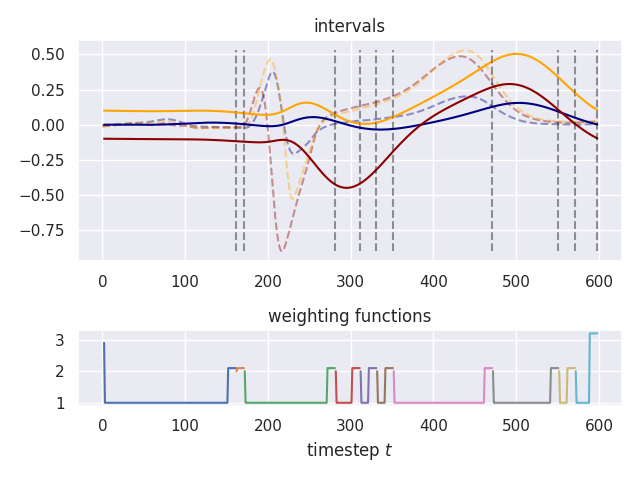

<ipython-input-23-b9f3fb790c17>:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


In [23]:
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 6)

f_ax1 = fig.add_subplot(gs[:4, :])
f_ax1.set_title('intervals')
f_ax1.plot(z_1_original, c='navy', linestyle='--', alpha=.4, label='$z_1$ original')
f_ax1.plot(z_2_original, c='darkred', linestyle='--', alpha=.4, label='$z_2$ original')
f_ax1.plot(z_3_original, c='orange', linestyle='--', alpha=.4, label='$z_3$ original')
for i in range(len(series_intervals)):
    el = series_intervals[i]
    series = el[0]
    
    f_ax1.plot(el[2], series[0], c='navy', label='$z_1$ interval %i' % (i))
    f_ax1.plot(el[2], series[1], c='darkred', label='$z_2$ interval %i' % (i))
    f_ax1.plot(el[2], series[2], c='orange', label='$z_3$ interval %i' % (i))
    
    f_ax1.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
               c='black', alpha=.4, linestyle='--')

f_ax2 = fig.add_subplot(gs[4:, :], sharex=f_ax1)
f_ax2.set_title('weighting functions')
for i in range(len(series_intervals)):
    el = series_intervals[i]
    f_ax2.plot(el[2], el[3])
f_ax2.set_xlabel('timestep $t$')
    
fig.tight_layout()
fig.show()

In [24]:
cu.polynominal = cu._polynominal

In [25]:
DEBUG = False

def debug_retrieve_fit_coefficients(self, z: list):
        '''
        parameters:
            - <1d-array> z: target time series to be fitted to
        '''
        print('- DEBUG function -')
        debug_output_a = ''
        
        polynominal_exponents = cu.polynominal(self.dimension, self.grade)
    
        len_polynominal = len(polynominal_exponents[0])
    
        a = np.ones((len_polynominal, len_polynominal))
        for i in range(len_polynominal):
            for j in range(len_polynominal):
                tmp = np.ones(np.shape(self.series[0]))
                for k in range(self.dimension):
                    y = self.series[k]
                    tmp *= y ** (polynominal_exponents[k][j] + polynominal_exponents[k][i])
                    
                    debug_output_a += '%i-' % ((polynominal_exponents[k][j] + polynominal_exponents[k][i]))
                    
                tmp *= self.weighting  # DEBUG: weighting here
                
                a[i][j] *= np.sum(tmp)
                
                debug_output_a += '| '
            debug_output_a += '\n'
        debug_output_b = ''
        
        b = np.ones((len_polynominal, 1))
        for i in range(len_polynominal):
            tmp = np.ones(np.shape(self.series[0]))
            for k in range(self.dimension):
                y = self.series[k]
                tmp *= y ** polynominal_exponents[k][i]
                
                debug_output_b += '%i-' % (polynominal_exponents[k][i])
            debug_output_b +='\n'
                
            tmp *= self.weighting  # DEBUG: weighting here
            b[i] *= np.sum(z * tmp)
            
        if DEBUG:
            print('a:')
            print(debug_output_a)
            print('A:')
            print(a == 0.)
            print('b:')
            print(debug_output_b)
            
        return np.linalg.solve(a, b)

ru.Model._retrieve_fit_coefficients = debug_retrieve_fit_coefficients

In [26]:
grade = 2

In [27]:
models = []

for i in range(len(series_intervals)):
    #if i == 1:
    #    break
    
    series = series_intervals[i][0]
    series_derivate = series_intervals[i][1]
    series_timeframe = list(series_intervals[i][2])
    series_weighting = series_intervals[i][3]

    f = 1024
    reconstruction_timeframe = np.linspace(series_timeframe[0], series_timeframe[-1], len(series_timeframe) * f)
    
    system = ru.Model(series, grade=grade, derivate=series_derivate, weighting=series_weighting)
    
    ivp = None 
    # this snippet is for continous integration, e.g. having the last result as ivp for next interval.
    # its kinda the same as below but with intrinsically hard gammas, which can not be changed.
    if i > 0 and 1:
        ivp = [models[-1][0].solution.T[0][-1],
               models[-1][0].solution.T[1][-1],
               models[-1][0].solution.T[2][-1]]
        
    res = system.evaluate(ivp=ivp)
    
    models.append([
                   system,
                   series_timeframe,
                   reconstruction_timeframe,
                  ])

- DEBUG function -
- DEBUG function -
- DEBUG function -
no initial values defined.
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -


/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -
- DEBUG function -


<IPython.core.display.Javascript object>


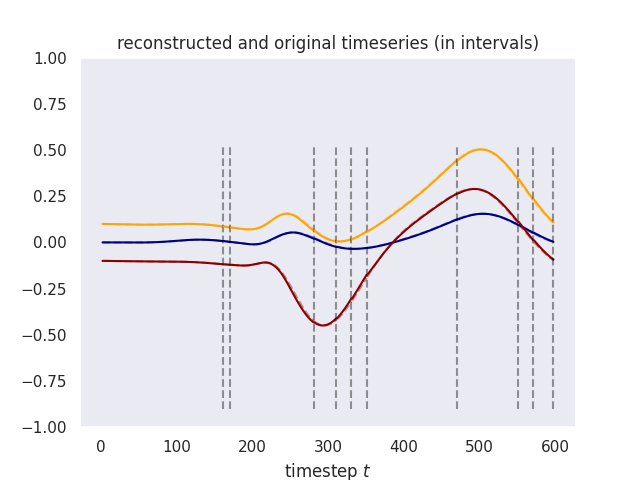

In [28]:
%matplotlib notebook
for el in models:
    plt.plot(el[1], el[0].series[0], linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
    plt.plot(el[1], el[0].series[1], linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
    plt.plot(el[1], el[0].series[2], linestyle='--', alpha=.4, label='$z_3$ original', c='orange')

    plt.plot(el[2], el[0].solution.T[0], label='$z_1$ reconstructed', c='navy')
    plt.plot(el[2], el[0].solution.T[1], label='$z_2$ reconstructed', c='darkred')
    plt.plot(el[2], el[0].solution.T[2], label='$z_3$ reconstructed', c='orange')
    
    plt.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
               c='black', alpha=.4, linestyle='--')

plt.title('reconstructed and original timeseries (in intervals)')
plt.xlabel('timestep $t$')
plt.grid()

plt.ylim([-1, 1])

#plt.legend()
plt.show()

In [29]:
t = np.linspace(0, len(z_1_original), 2000)

In [30]:
gamma = []

epsilon = .5  # below gamma shall return 0
linear_fade_in_duration = 3#2e-9 #20

for i in range(len(intervals)):
    li = intervals[i][0]
    gi = intervals[i][1]

    if gi == -1:
        gi = len(z_1_original) + 100
    if li == 0:
        li = -100

    o = (np.arctan(t - li) - np.arctan(t - gi))
    o_max = np.max(o)


    def _1(t, i=i, li=li, gi=gi, o_max=o_max):
        #tmp = (np.arctan(t - li) - np.arctan(t - gi)) / o_max
        #return tmp * (tmp > epsilon)
        
        if li + (linear_fade_in_duration / 2) <= t <= gi - (linear_fade_in_duration / 2):
            return 1.
        elif li - (linear_fade_in_duration / 2) < t < li + (linear_fade_in_duration / 2):
            return (t - li - (linear_fade_in_duration / 2)) * (1 / linear_fade_in_duration) + 1
        elif gi - (linear_fade_in_duration / 2) < t < gi + (linear_fade_in_duration / 2):
            return - (t - gi - (linear_fade_in_duration / 2)) * (1 / linear_fade_in_duration)
        else:
            return 0.
    
    gamma.append(_1)

<IPython.core.display.Javascript object>


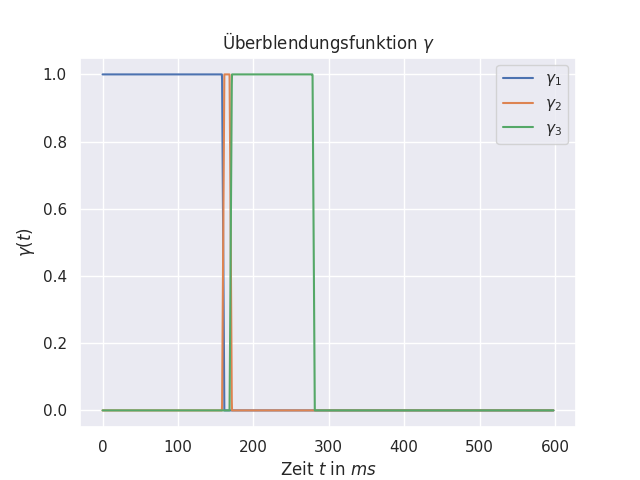

In [31]:
%matplotlib notebook
i = 0
for el in gamma:
    plt.plot(t, [el(sel) for sel in t])
    i += 1
    if i == 3: break
plt.title('Überblendungsfunktion $\gamma$')
plt.xlabel('Zeit $t$ in $ms$')
plt.ylabel('$\gamma(t)$')
plt.legend(['$\gamma_1$', '$\gamma_2$', '$\gamma_3$'])
plt.show()

In [32]:
time_dependent_fit_coefficients = [[], [], []]

for i in range(len(models[0][0].fit_coefficients)):  # 3: p,q,r
    for j in range(len(models[0][0].fit_coefficients[i])):  # 34: p_0, ..., p_33
        #print(j)
        def _2(t, i=i, j=j):
            res = 0
            for k in range(len(gamma)):  # 8
                #print(i, j, k, np.shape(res))
                res += gamma[k](t) * models[k][0].fit_coefficients[i][j]
            return res
        time_dependent_fit_coefficients[i].append(_2)

In [33]:
sns.set_theme()

<IPython.core.display.Javascript object>


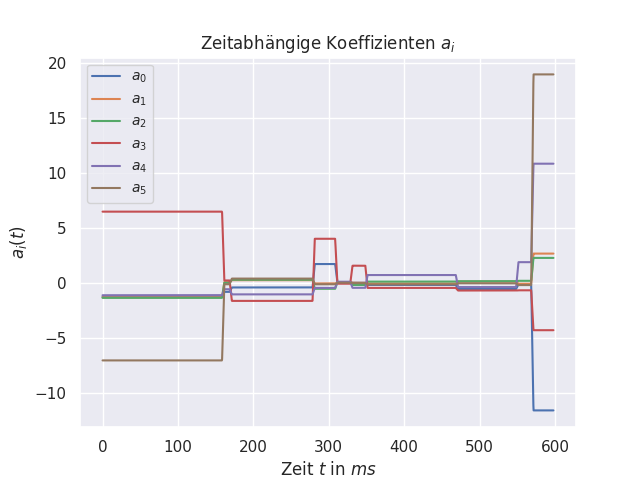

In [34]:
%matplotlib notebook
for i in range(len(time_dependent_fit_coefficients[0])):
    plt.plot(t, [time_dependent_fit_coefficients[0][i](el) for el in t], label='$a_%i$' % (i))
    if i == 5: break

#for i in range(len(models[0][0].fit_coefficients[0])):
#    #if 5 < i < 30: continue
#    if i == 5: break
#    plt.plot(t, [gamma[0](el) * models[0][0].fit_coefficients[0][i] for el in t], 
#             label='original $p_%i$' % (i), linestyle='dashdot')
#    plt.plot(t, [1. * models[0][0].fit_coefficients[0][i] for el in t], 
#             label='original $p_%i$' % (i), linestyle='--', alpha=.1)

#plt.plot(t, [1. * models[-1][0].fit_coefficients[0][i] for el in t], 
#             label='original $p_%i$' % (i), linestyle='--')
        
plt.title('Zeitabhängige Koeffizienten $a_i$')
plt.xlabel('Zeit $t$ in $ms$')
plt.ylabel('$a_i(t)$')
plt.legend(fontsize='small', loc='upper left')
plt.show()

In [35]:
def convert_fit_coefficients_to_function(p, grade, dimension=3):
    assert(dimension == 3)
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')

    #print('Polynominal of grade %i detected' % (grade))

    y_1_poly, y_2_poly, y_3_poly = cu.polynominal(dimension, grade)

    def func(y_1, y_2, y_3):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i] * y_3 ** y_3_poly[i]
        return res

    return func

In [36]:
def func(t, x, p, q, r, grade):
    '''        |  |  |
               fit-coefficients,
               need to be converted to function each iteration
    '''
    fit_to_y_1 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in p]), grade)
    fit_to_y_2 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in q]), grade)
    fit_to_y_3 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in r]), grade)
    
    y = [0, 0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1], x[2])[0]
    y[1] = fit_to_y_2(x[0], x[1], x[2])[0]
    y[2] = fit_to_y_3(x[0], x[1], x[2])[0]

    return y

In [37]:
index_start = 0#160
T = len(z_1_)
#T = 300

ivp = [0, 0, 0]
ivp[0] += z_1_[index_start]
ivp[1] += z_2_[index_start]
ivp[2] += z_3_[index_start]

In [38]:
f = 256#1024
t = np.linspace(index_start, index_start + T, T * f)

In [39]:
sol, infodict = odeint(func, ivp, t, 
                       args=(time_dependent_fit_coefficients[0], 
                             time_dependent_fit_coefficients[1], 
                             time_dependent_fit_coefficients[2], grade), 
                       tfirst=True, full_output=True, printmessg=True)

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


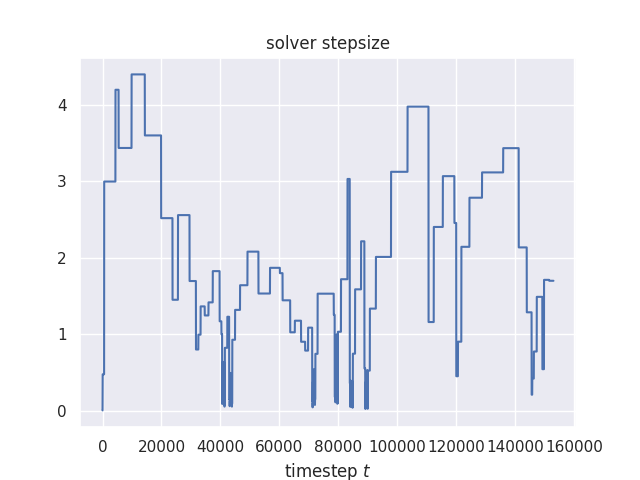

In [40]:
%matplotlib notebook
plt.plot(infodict['hu'])
plt.xlabel('timestep $t$')
plt.title('solver stepsize')
plt.show()

<IPython.core.display.Javascript object>


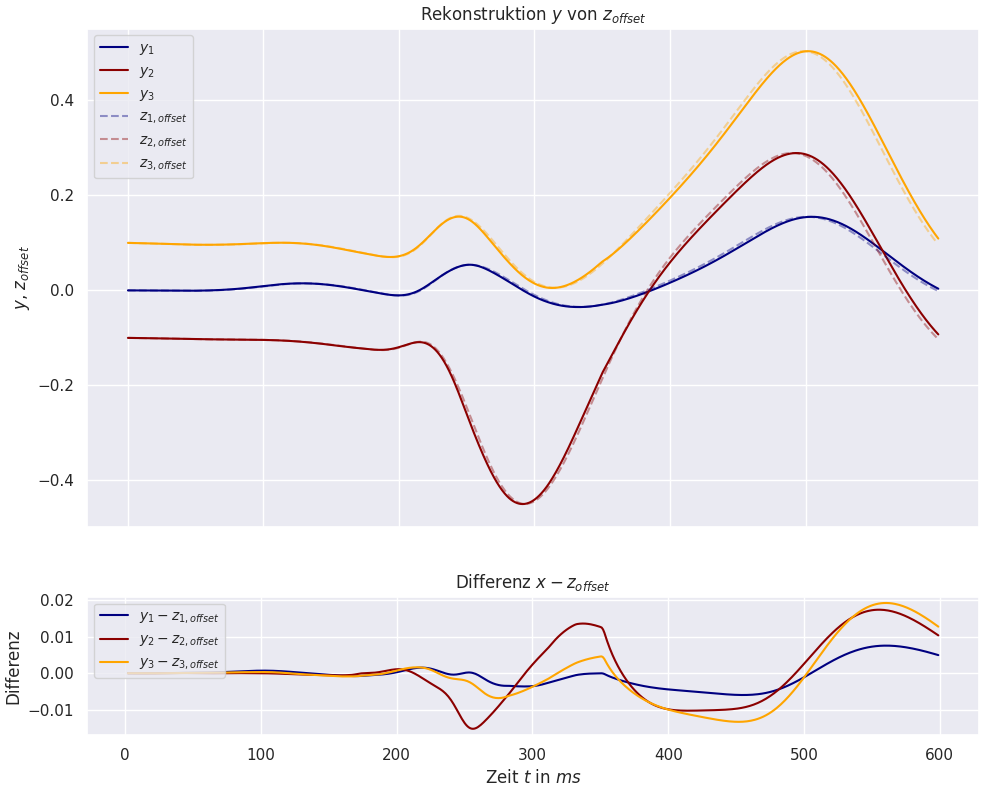

In [42]:
%matplotlib notebook
mi = -1

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(24, 24)

ax = fig.add_subplot(gs[:18, :])
ax.plot(t[:mi], sol[:mi,0], label='$y_1$', c='navy')
ax.plot(t[:mi], sol[:mi,1], label='$y_2$', c='darkred')
ax.plot(t[:mi], sol[:mi,2], label='$y_3$', c='orange')

ax.plot(timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_{1,offset}$', c='navy')
ax.plot(timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_{2,offset}$', c='darkred')
ax.plot(timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_{3,offset}$', c='orange')

#ax.set_title('Reconstruction $y$ of $z_{offset}$')
ax.set_title('Rekonstruktion $y$ von $z_{offset}$')
ax.set_ylabel('$y$, $z_{offset}$')
ax.legend(fontsize='small')
plt.xticks(range(0, 600, 100), [])

ax = fig.add_subplot(gs[19:, :])
#ax.set_title('Differences $|x-z_{offset}|$')
ax.set_title('Differenz $x-z_{offset}$')
ax.plot(timesteps_, [sol[:mi,0][i * f] - z_1_[i] for i in range(T)], label='$y_1-z_{1,offset}$', c='navy')
ax.plot(timesteps_, [sol[:mi,1][i * f] - z_2_[i] for i in range(T)], label='$y_2-z_{2,offset}$', c='darkred')
ax.plot(timesteps_, [sol[:mi,2][i * f] - z_3_[i] for i in range(T)], label='$y_3-z_{3,offset}$', c='orange')
ax.legend(fontsize='small', loc='upper left')
#ax.set_xlabel('Time $t$ in $ms$')
ax.set_xlabel('Zeit $t$ in $ms$')
#ax.set_ylabel('Difference')
ax.set_ylabel('Differenz')
#plt.yticks([-.01, 0., .01])

#plt.tight_layout()
plt.show()

In [46]:
mse_1 = np.sum((np.array([sol[:mi,0][i * f] - z_1_[i] for i in range(T)])) ** 2) / T
mse_2 = np.sum((np.array([sol[:mi,1][i * f] - z_2_[i] for i in range(T)])) ** 2) / T
mse_3 = np.sum((np.array([sol[:mi,2][i * f] - z_3_[i] for i in range(T)])) ** 2) / T

print(mse_1, mse_2, mse_3)

1.163538665384288e-05 6.919129340910423e-05 6.436041591388948e-05


In [315]:
ivp_last = (sol[0,0], sol[0,1], sol[0,2])
print(ivp_last)
print(ivp_last[0] - z_1_[0], ivp_last[1] - z_1_[1], ivp_last[2] - z_1_[2])

(-1.8485145792384115e-08, -0.10000004291060387, 0.0999999598018332)
0.0 -0.0999809320283866 0.10003837924473728


# Periodic continuation

In [317]:
t = np.linspace(0, len(z_1_original) * 2, 2000)

In [318]:
len_series_full = len(z_1_)

In [319]:
gamma_contd = []

epsilon = .5  # below gamma shall return 0
linear_fade_in_duration = 3#2e-9 #20

for i in range(len(intervals)):
    li = intervals[i][0]
    gi = intervals[i][1]

    if gi == - 1:
        gi = len(z_1_original)# + linear_fade_in_duration / 2
    if li == 0:
        li = 0#- linear_fade_in_duration

    o = (np.arctan(t - li) - np.arctan(t - gi))
    o_max = np.max(o)


    def _1(t, i=i, li=li, gi=gi, o_max=o_max):
        #tmp = (np.arctan(t - li) - np.arctan(t - gi)) / o_max
        #return tmp * (tmp > epsilon)
        
        if li + (linear_fade_in_duration / 2) <= t % len_series_full <= gi - (linear_fade_in_duration / 2):
            return 1.
        elif li - (linear_fade_in_duration / 2) < t % len_series_full < li + (linear_fade_in_duration / 2):
            return (t % len_series_full - li - (linear_fade_in_duration / 2)) * (1 / linear_fade_in_duration) + 1
        elif gi - (linear_fade_in_duration / 2) < t % len_series_full < gi + (linear_fade_in_duration / 2):
            return - (t % len_series_full - gi - (linear_fade_in_duration / 2)) * (1 / linear_fade_in_duration)
        else:
            return 0.
    
    gamma_contd.append(_1)

<IPython.core.display.Javascript object>


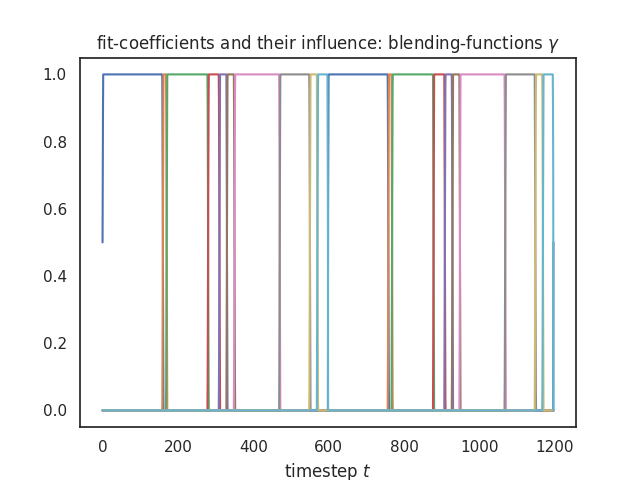

In [320]:
%matplotlib notebook
for el in gamma_contd:#(gamma_contd[0], gamma_contd[3]):
    plt.plot(t, [el(sel) for sel in t])
plt.title('fit-coefficients and their influence: blending-functions $\gamma$')
plt.xlabel('timestep $t$')
plt.show()

In [321]:
time_dependent_fit_coefficients_contd = [[], [], []]

for i in range(len(models[0][0].fit_coefficients)):  # 3: p,q,r
    for j in range(len(models[0][0].fit_coefficients[i])):  # 34: p_0, ..., p_33
        #print(j)
        def _2(t, i=i, j=j):
            res = 0
            for k in range(len(gamma_contd)):  # 8
                #print(i, j, k, np.shape(res))
                res += gamma_contd[k](t) * models[k][0].fit_coefficients[i][j]
            return res
        time_dependent_fit_coefficients_contd[i].append(_2)

In [322]:
def convert_fit_coefficients_to_function(p, grade, dimension=3):
    assert(dimension == 3)
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')

    #print('Polynominal of grade %i detected' % (grade))

    y_1_poly, y_2_poly, y_3_poly = cu.polynominal(dimension, grade)

    def func(y_1, y_2, y_3):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i] * y_3 ** y_3_poly[i]
        return res

    return func

In [323]:
def func_contd(t, x, p, q, r, grade):
    '''        |  |  |
               fit-coefficients,
               need to be converted to function each iteration
    '''
    fit_to_y_1 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in p]), grade)
    fit_to_y_2 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in q]), grade)
    fit_to_y_3 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in r]), grade)
    
    #if t % len_series_full < .01 and t > 10:
    #    return ivp
    
    y = [0, 0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1], x[2])[0]
    y[1] = fit_to_y_2(x[0], x[1], x[2])[0]
    y[2] = fit_to_y_3(x[0], x[1], x[2])[0]

    return y

In [330]:
index_start = 0#160
T = len(z_1_)# * 2
#T = 300

ivp = [0, 0, 0]
ivp[0] += z_1_[index_start]
ivp[1] += z_2_[index_start]
ivp[2] += z_3_[index_start]

In [331]:
f = 256#1024
t = np.linspace(index_start, index_start + T, T * f)

In [332]:
sol_second, infodict = odeint(func_contd, [sol[-1,0], sol[-1,1], sol[-1,2]], t, 
                       args=(time_dependent_fit_coefficients_contd[0], 
                             time_dependent_fit_coefficients_contd[1], 
                             time_dependent_fit_coefficients_contd[2], grade), 
                       tfirst=True, full_output=True, printmessg=True)

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [333]:
#sol_second = sol

<IPython.core.display.Javascript object>


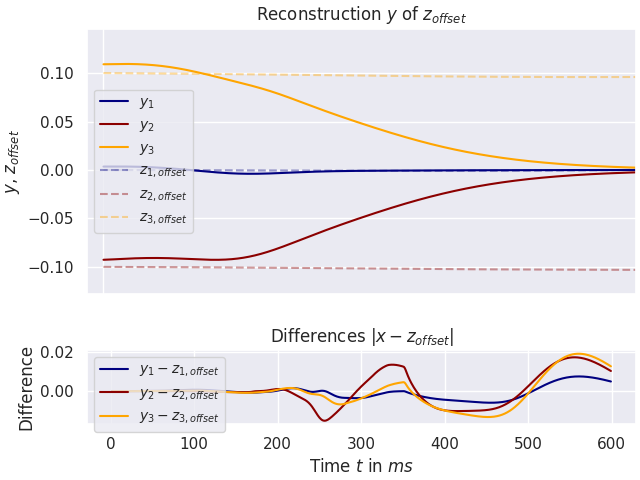

In [413]:
%matplotlib notebook
mi = -1

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(24, 24)

ax = fig.add_subplot(gs[:18, :])
ax.plot(t[:mi], sol_second[:mi,0], label='$y_1$', c='navy')
ax.plot(t[:mi], sol_second[:mi,1], label='$y_2$', c='darkred')
ax.plot(t[:mi], sol_second[:mi,2], label='$y_3$', c='orange')

ax.plot(timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_{1,offset}$', c='navy')
ax.plot(timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_{2,offset}$', c='darkred')
ax.plot(timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_{3,offset}$', c='orange')

ax.set_title('Reconstruction $y$ of $z_{offset}$')
ax.set_ylabel('$y$, $z_{offset}$')
ax.legend(fontsize='small')
plt.xticks(range(0, 600, 100), [])
plt.ylim([-100, 100])

ax = fig.add_subplot(gs[19:, :])
ax.set_title('Differences $|x-z_{offset}|$')
ax.plot(timesteps_, [sol[:mi,0][i * f] - z_1_[i] for i in range(T)], label='$y_1-z_{1,offset}$', c='navy')
ax.plot(timesteps_, [sol[:mi,1][i * f] - z_2_[i] for i in range(T)], label='$y_2-z_{2,offset}$', c='darkred')
ax.plot(timesteps_, [sol[:mi,2][i * f] - z_3_[i] for i in range(T)], label='$y_3-z_{3,offset}$', c='orange')
ax.legend(fontsize='small', loc='upper left')
ax.set_xlabel('Time $t$ in $ms$')
ax.set_ylabel('Difference')
#plt.yticks([-.01, 0., .01])

#plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


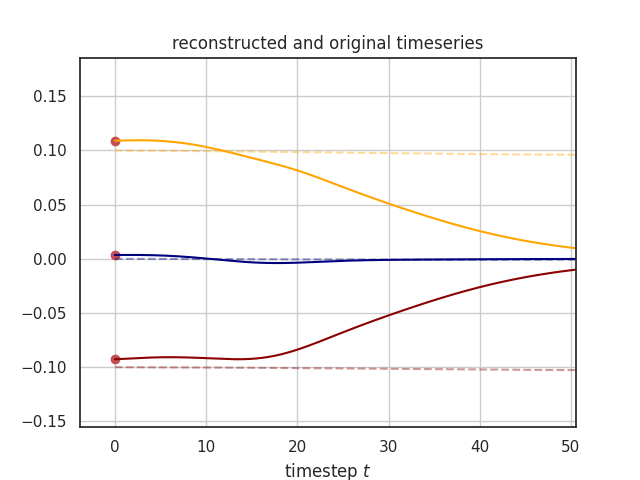

In [334]:
%matplotlib notebook
mi = -1

plt.plot(t[:mi], sol_second[:mi,0], label='$z_1$ reconstructed', c='navy')
plt.plot(t[:mi], sol_second[:mi,1], label='$z_2$ reconstructed', c='darkred')
plt.plot(t[:mi], sol_second[:mi,2], label='$z_3$ reconstructed', c='orange')

plt.plot(timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
plt.plot(len_series_full + timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_1$ original', c='navy')

plt.plot(timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
plt.plot(len_series_full + timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')

plt.plot(timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_3$ original', c='orange')
plt.plot(len_series_full + timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_3$ original', c='orange')

for i in range(len(series_intervals)):
    el = series_intervals[i]
    plt.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
             c='black', alpha=.4, linestyle='--')

plt.title('reconstructed and original timeseries')
plt.xlabel('timestep $t$')
plt.grid()

plt.scatter([0, 0, 0], [sol[-1,0], sol[-1,1], sol[-1,2]], c='r')
#plt.scatter([0, 0, 0], ivp, c='b')

#plt.legend()

plt.ylim([-1000,1000])

plt.show()

<IPython.core.display.Javascript object>


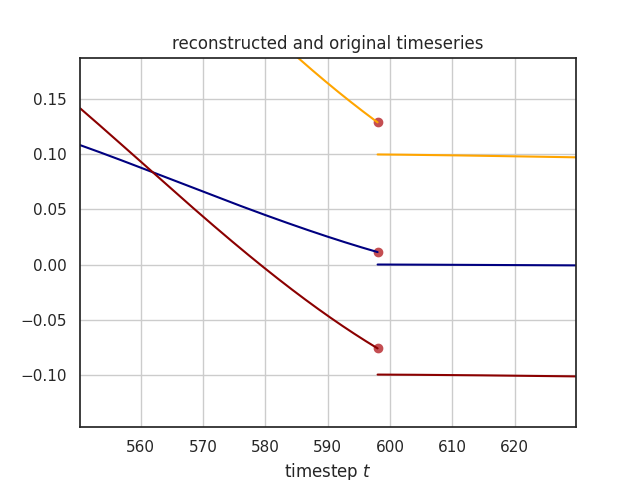

In [112]:
%matplotlib notebook
mi = -1

plt.plot(t, sol[:,0], label='$z_1$ reconstructed', c='navy')
plt.plot(t, sol[:,1], label='$z_2$ reconstructed', c='darkred')
plt.plot(t, sol[:,2], label='$z_3$ reconstructed', c='orange')

plt.plot(t + t[-1], sol_second[:,0], label='$z_1$ reconstructed', c='navy')
plt.plot(t + t[-1], sol_second[:,1], label='$z_2$ reconstructed', c='darkred')
plt.plot(t + t[-1], sol_second[:,2], label='$z_3$ reconstructed', c='orange')

#plt.plot(timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
#plt.plot(len_series_full + timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
#
#plt.plot(timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
#plt.plot(len_series_full + timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
#
#plt.plot(timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_3$ original', c='orange')
#plt.plot(len_series_full + timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_3$ original', c='orange')
#
#for i in range(len(series_intervals)):
#    el = series_intervals[i]
#    plt.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
#             c='black', alpha=.4, linestyle='--')

plt.title('reconstructed and original timeseries')
plt.xlabel('timestep $t$')
plt.grid()

plt.scatter(t[-1]*np.array([1, 1, 1]), [sol[-1,0], sol[-1,1], sol[-1,2]], c='r')
#plt.scatter([0, 0, 0], ivp, c='b')

#plt.legend()

#plt.ylim([-1000,1000])

plt.show()